# Aims and objectives

## Context

A loan default occurs when a borrower fails to make required payments on their debt. We’ll investigate quantitative factors which contribute to a borrower defaulting on a loan, using exploratory data analysis. We’ll use the insights to decide on approving future loans.

## Aims

We wish to analyse 100 loans to ascertain characteristics of borrowers, and observe any patterns and trends which may be indicative of a borrower being unable to pay back thier loan. We then wish to define a borrower by a set of characteristics, and a loan by a series of control variables. Our target variable is the outcome of the borrower being able to repay the loan. 

Upon the borrower selection process, we wish to minimise the factors which correlate with a borrower being unable to repay the loan. We will also identify and optimise control variables which can minimise risk, proportional to the properties of the borrower's affordability profile.

## Objectives

- What makes a good borrower?
- What variables can we control to reduce defaults?
- What are the limitations of the data?

## Data dictionary

[Link](https://docs.google.com/spreadsheets/d/1zeaWMqX_PJRR5ikTsY-bV2Hw7pGArNpZhmlsvUjQI18/edit?gid=461848584#gid=461848584) to the data set.
* `credit_policy`: Whether the applicant meets basic credit criteria
* `purpose`: The stated purpose of the loan
* `int_rate`: The interest rate assigned to the loan
* `installment`: Monthly payment amount
* `log_annual_inc`: Natural log of the applicant's annual income
* `dti`: Debt-to-income ratio
* `fico`: FICO credit score
* `days_with_cr_line`: Length of credit history
* `revol_bal`: Revolving balance
* `revol_util`: Revolving utilisation rate
* `inq_last_6mths`: Number of credit inquiries in the last 6 months
* `delinq_2yrs`: Number of delinquencies in the past 2 years
* `pub_rec`: Number of derogatory public records
* `not_fully_paid`: Target variable (1 = unpaid, 0 = paid)

# ETL

## Init

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

## Data extraction and load

In [3]:
df = pd.read_csv('Data_Loan.csv')
df.head(10)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
5,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,0,0,0,0
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0,0,1,1
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0,0,0,1
8,1,home_improvement,0.1134,87.19,11.407565,17.25,682,3989.000000,69909,51.1,1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0,0


Rename columns with `.` to have an `_` separator instead.

In [4]:
df.columns = [c.replace(".", "_") for c in list(df.columns)]

Drop `credit_policy` because it's redundant.

In [5]:
if len(df['credit_policy'].unique()) == 1:
    df = df.drop(labels='credit_policy', axis=1)

Check for null values.

In [6]:
df.isna().any()

purpose              False
int_rate             False
installment          False
log_annual_inc       False
dti                  False
fico                 False
days_with_cr_line    False
revol_bal            False
revol_util           False
inq_last_6mths       False
delinq_2yrs          False
pub_rec              False
not_fully_paid       False
dtype: bool

Cast `not_fully_paid` as boolean.

In [7]:
df['not_fully_paid'] = df['not_fully_paid'].astype('bool')

Data cleansing complete.

In [8]:
df

,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,False
1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,False
2,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,False
3,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,False
4,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,debt_consolidation,0.0775,156.11,10.714418,5.00,762,2131.000000,1359,5.6,2,0,0,False
96,debt_consolidation,0.1154,329.95,12.323856,20.00,727,10292.000000,107501,44.8,2,0,0,False
97,all_other,0.0807,313.67,12.061047,0.72,787,8010.000000,3054,5.6,3,0,0,False
98,all_other,0.0807,297.99,11.407565,2.44,792,8717.958333,40384,9.6,0,0,0,False


## Data transformation

### Schema

Preview values in dataset to determine categorical vs numerical modelling.

In [9]:
for col in df:
    unique_values = df[col].unique()
    #if len(unique_values) <= 10:
    print(f"Column: {col}")
    print("Unique values:", unique_values, "\n")

Column: purpose
Unique values: ['debt_consolidation' 'credit_card' 'all_other' 'home_improvement'
 'small_business' 'major_purchase' 'educational'] 

Column: int_rate
Unique values: [0.1189 0.1071 0.1357 0.1008 0.1426 0.0788 0.1496 0.1114 0.1134 0.1221
 0.1347 0.1324 0.0859 0.0714 0.0863 0.1103 0.1317 0.0894 0.1039 0.1513
 0.08   0.1355 0.1229 0.0901 0.0743 0.1375 0.0807 0.1028 0.087  0.1122
 0.0996 0.0933 0.0838 0.0775 0.1059 0.1596 0.1154 0.1343 0.1249 0.0964
 0.1186 0.1501 0.128  0.1091 0.1217 0.1533] 

Column: installment
Unique values: [829.1  228.22 366.86 162.34 102.92 125.13 194.02 131.22  87.19  84.12
 360.43 253.58 316.11  92.82 209.54 327.53  77.69 476.58 584.12 173.65
 188.02 474.42 339.6  484.85 320.19 159.03 155.38 255.43 156.84 275.38
  78.42 158.3  164.23 161.25 159.77  94.98  97.2  167.02 168.6  160.72
 178.69 323.98 813.65 112.87  94.88 398.69  39.6  678.08 401.37 205.45
 397.75 113.39  99.44 109.79  32.55 160.51 340.57 156.11 235.25 257.99
 225.37  80.26  84.   507.4

### Categorical data

In [31]:
df_cat = pd.DataFrame([
    df['purpose'],
    df['inq_last_6mths'].astype("category"),
    df['delinq_2yrs'].astype("category"),
    df['pub_rec'].astype("category")
]).T
df_cat

,purpose,inq_last_6mths,delinq_2yrs,pub_rec
0,debt_consolidation,0,0,0
1,credit_card,0,0,0
2,debt_consolidation,1,0,0
3,debt_consolidation,1,0,0
4,credit_card,0,1,0
...,...,...,...,...
95,debt_consolidation,2,0,0
96,debt_consolidation,2,0,0
97,all_other,3,0,0
98,all_other,0,0,0


We exclude `not_fully_paid` since it's our target variable. Instead, we'll use it as a filter.

### Numerical data

In [32]:
df_num = pd.DataFrame([
    df['int_rate'],
    df['installment'],
    df['log_annual_inc'],
    df['dti'],
    df['days_with_cr_line'],
    df['revol_bal'],
    df['revol_util'],
    df['fico']
]).T
df_num

,int_rate,installment,log_annual_inc,dti,days_with_cr_line,revol_bal,revol_util,fico
0,0.1189,829.10,11.350407,19.48,5639.958333,28854.0,52.1,737.0
1,0.1071,228.22,11.082143,14.29,2760.000000,33623.0,76.7,707.0
2,0.1357,366.86,10.373491,11.63,4710.000000,3511.0,25.6,682.0
3,0.1008,162.34,11.350407,8.10,2699.958333,33667.0,73.2,712.0
4,0.1426,102.92,11.299732,14.97,4066.000000,4740.0,39.5,667.0
...,...,...,...,...,...,...,...,...
95,0.0775,156.11,10.714418,5.00,2131.000000,1359.0,5.6,762.0
96,0.1154,329.95,12.323856,20.00,10292.000000,107501.0,44.8,727.0
97,0.0807,313.67,12.061047,0.72,8010.000000,3054.0,5.6,787.0
98,0.0807,297.99,11.407565,2.44,8717.958333,40384.0,9.6,792.0


# EDA

In [65]:
sns.set_theme()

## Univariate

### Descriptive statistics

#### Paid loans

In [34]:
df_num[df['not_fully_paid'] == False].describe()

,int_rate,installment,log_annual_inc,dti,days_with_cr_line,revol_bal,revol_util,fico
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.098923,223.491778,11.092679,8.763889,4634.350000,17188.522222,33.861111,729.444444
std,0.022623,151.752754,0.711382,5.957935,2701.846875,23392.569414,26.019797,45.160416
min,0.071400,39.600000,8.987197,0.000000,1126.958333,0.000000,0.000000,627.000000
25%,0.080700,125.950000,10.626080,3.467500,2699.958333,3097.250000,13.775000,694.500000
50%,0.093300,160.615000,11.177233,7.985000,4182.000000,7059.000000,26.200000,727.000000
75%,0.112200,297.990000,11.512925,14.350000,5939.750000,21950.250000,51.950000,767.000000
max,0.159600,829.100000,12.429216,22.090000,14008.958330,128000.000000,93.400000,812.000000


#### Unpaid loans

In [35]:
df_num[df['not_fully_paid'] == True].describe()

,int_rate,installment,log_annual_inc,dti,days_with_cr_line,revol_bal,revol_util,fico
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.119970,267.974000,10.958715,11.475000,3911.787500,15398.200000,50.250000,701.000000
std,0.019775,245.534131,0.783348,5.927931,1850.599204,19257.530734,23.900918,33.977116
min,0.096400,32.550000,9.615805,2.860000,1110.000000,269.000000,3.800000,667.000000
25%,0.107275,89.190000,10.474525,7.375000,2437.510417,3515.750000,35.550000,678.250000
50%,0.113800,162.620000,10.858259,11.660000,4565.458333,5499.000000,48.800000,684.500000
75%,0.132725,436.937500,11.410388,14.227500,5305.718750,20739.000000,72.725000,719.500000
max,0.150100,678.080000,12.269047,20.000000,6240.000000,56411.000000,76.800000,772.000000


### Data distribution

#### Categorical data

Proportion of categories in `False` or `True`:

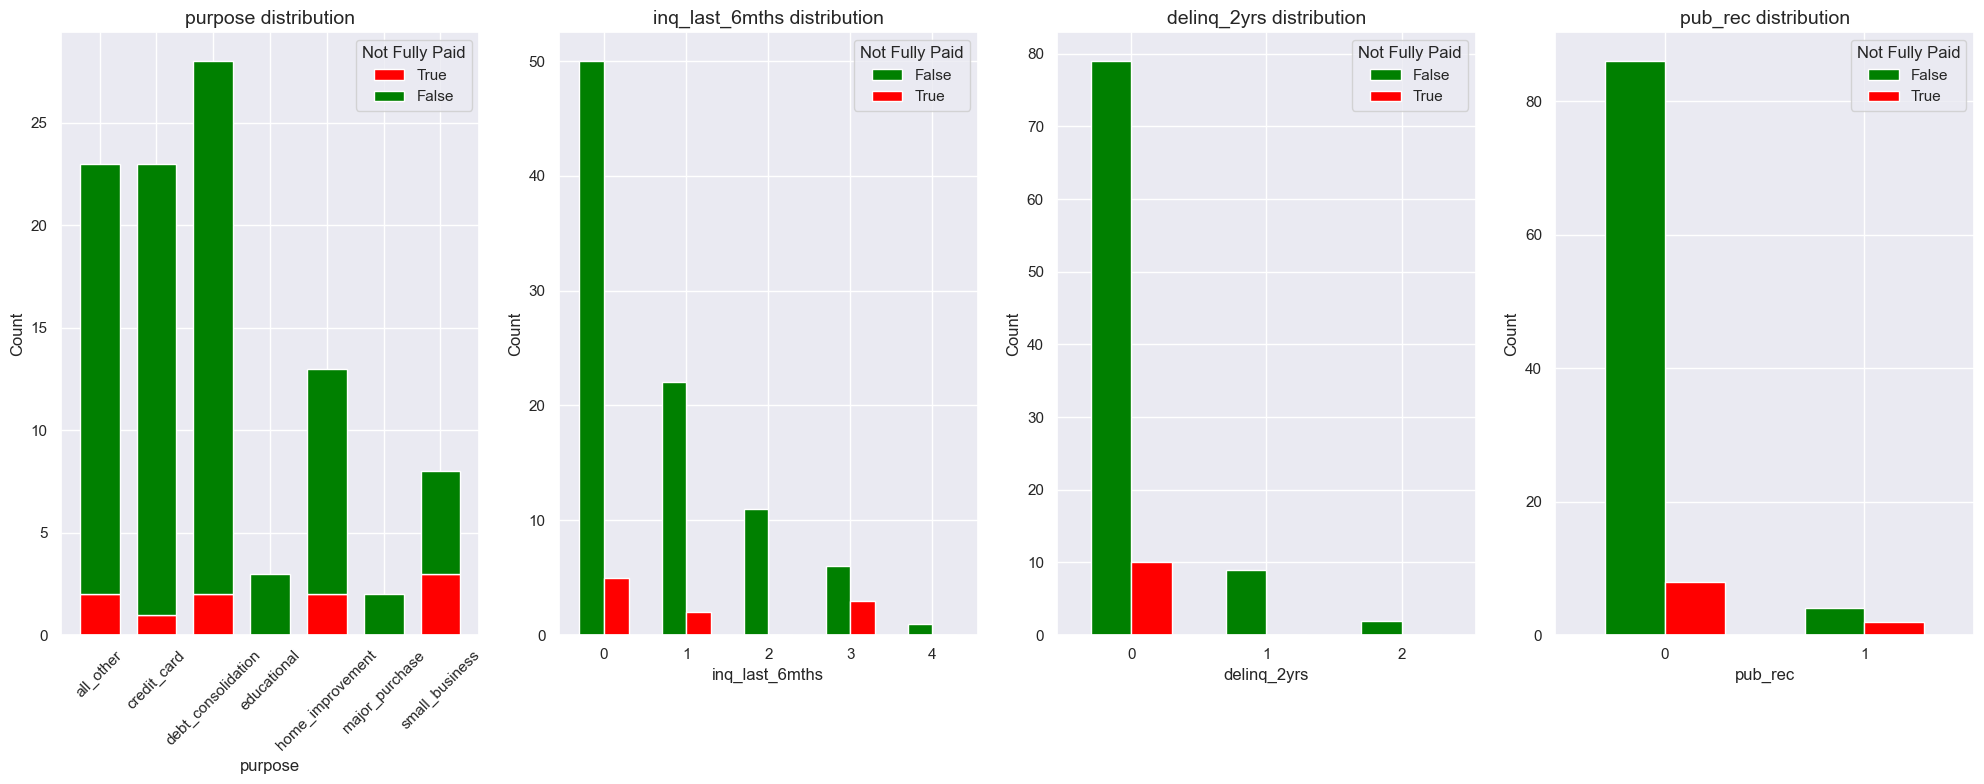

In [119]:
# Define columns to plot
columns = df_cat.columns

# Define a color palette
palette = {False: 'green', True: 'red'}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(20, 8))

for ax, col in zip(axes, columns):
    # Group and sort values for better clarity
    sorted_counts = df.groupby([col, 'not_fully_paid']).size().unstack().fillna(0)
    
    if col == 'purpose':
        # Calculate proportions for stacking
        bottom = sorted_counts[False]
        
        # Plot stacked bar plot for 'purpose'
        ax.bar(sorted_counts.index, sorted_counts[True], color=palette[True], label='True', width=0.7)
        ax.bar(sorted_counts.index, sorted_counts[False], bottom=sorted_counts[True], color=palette[False], label='False', width=0.7)
        ax.set_title(f'{col} distribution', fontsize=14)
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    else:
        # Plot individual bar plot for other columns
        sorted_counts.plot(kind='bar', stacked=False, color=[palette[False], palette[True]], ax=ax, width=0.6)
        ax.set_title(f'{col} distribution', fontsize=14)
        ax.tick_params(axis='x', rotation=0)  # Keep x-axis labels horizontal
    
    # Customize each subplot
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='Not Fully Paid', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

#### Numerical data

/var/folders/w0/mkf6nqcx2_s0xg85xfrzd05h0000gn/T/ipykernel_79892/1549638171.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)


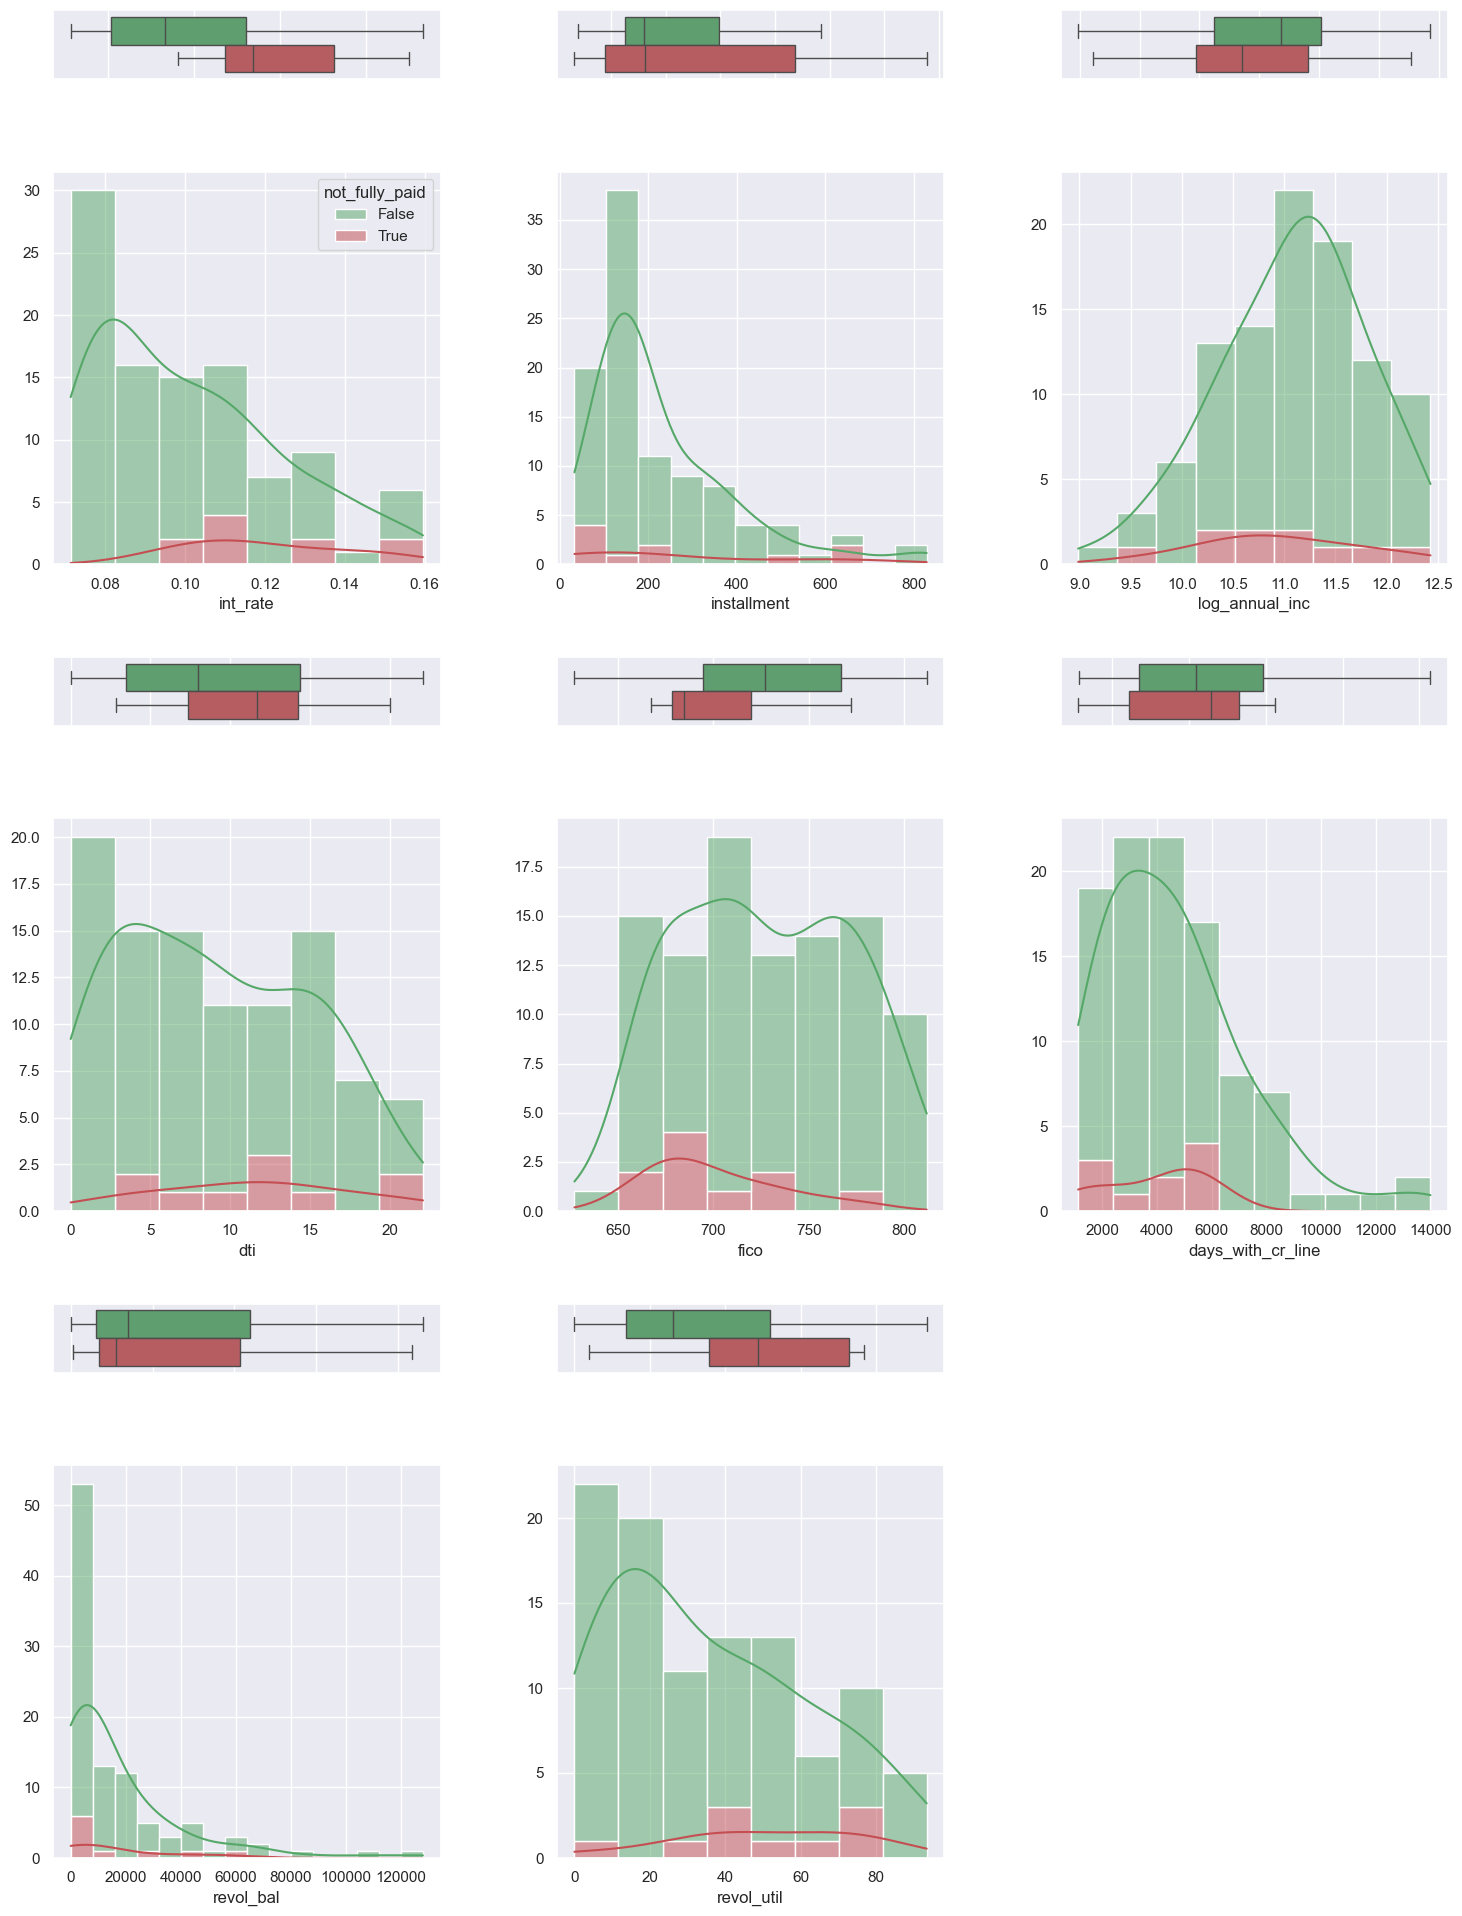

In [130]:
palette = {True: 'r', False: 'g'}
num_cols = 3  # Number of columns per row

# Filter only numerical columns and exclude 'not_fully_paid' and categorical columns
numerical_columns = [col for col in df.select_dtypes(include=['number']).columns if col != 'not_fully_paid' and col not in df_cat]

# Calculate the number of rows needed
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

# Adjust the height of the figure and set wspace and hspace for desired spacing
fig, axes = plt.subplots(num_rows * 2, num_cols, figsize=(18, num_rows * 8), gridspec_kw={"height_ratios": [0.15, 0.85] * num_rows, "wspace": 0.3, "hspace": 0.4})

for i, col in enumerate(numerical_columns):
    row = (i // num_cols) * 2  # Determine which row pair to work on
    col_idx = i % num_cols     # Determine the column index within the grid
    
    # Create the boxplot on top with a slim y-axis
    sns.boxplot(data=df, x=col, hue='not_fully_paid', palette=palette, ax=axes[row, col_idx], showfliers=False, legend=False)
    axes[row, col_idx].set(ylabel='', xlabel='')  # Remove labels
    axes[row, col_idx].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis labels for box plot

    # Create the histogram below the boxplot
    sns.histplot(data=df, x=col, hue='not_fully_paid', multiple='stack', kde=True, palette=palette, ax=axes[row + 1, col_idx], legend=(i == 0))
    axes[row + 1, col_idx].set(ylabel='')  # Remove y-axis label

# Remove empty subplots if the number of columns is not a perfect multiple of num_cols
for j in range(len(numerical_columns), num_rows * num_cols):
    fig.delaxes(axes[(j // num_cols) * 2, j % num_cols])
    fig.delaxes(axes[(j // num_cols) * 2 + 1, j % num_cols])

plt.tight_layout(pad=2.0)
plt.show()

#### Skew analysis

Strong data skews:
- Paid +ve: `int_rate`, `installment`, `dti`, `revol_bal`, `revol_util`
- Paid -ve: `log_annual_inc`
- Unpaid +ve: `int_rate`, `installment`, `log_annual_inc`, `fico`, `revol_bal`, `revol_util`
- Unpaid -ve: `days_with_cr_line`, `dti`

Key: 
- Positive indicates outliers at higher values
- Negative indicates outliers at lower values

#### Chi-squared test

In [142]:
# Prepare a list to store the results
results_list = []

for col in df.columns:
    if col != 'not_fully_paid':  # Skip the target variable itself
        # Create a contingency table
        contingency_table = pd.crosstab(df[col], df['not_fully_paid'])
        
        # Perform the Chi-Squared test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Append the results to the list
        results_list.append({
            "Category": col,
            "Chi2 Statistic": chi2,
            "p-value": p,
            "DoF": dof
        })

# Convert the list to a DataFrame
chi2_results = pd.DataFrame(results_list)

# Sorting the results by p-value for easier interpretation
chi2_results = chi2_results.sort_values(by="p-value").reset_index(drop=True)

# Display the DataFrame
chi2_results

,Category,Chi2 Statistic,p-value,DoF
0,int_rate,62.962963,0.039551,45
1,installment,100.000000,0.086070,82
2,inq_last_6mths,6.902357,0.141139,4
3,purpose,8.810453,0.184522,6
4,pub_rec,1.595745,0.206507,1
5,days_with_cr_line,100.000000,0.221040,90
6,revol_util,100.000000,0.266866,92
7,revol_bal,100.000000,0.342833,95
8,log_annual_inc,60.555556,0.383766,58
9,dti,92.592593,0.404772,90


After an evaluation of the $\chi^2$ test, only the `int_rate` category had a $p<0.05$. This suggests that `int_rate` was the only distribution which had a significant influence on whether a loan could be repaid or not.

## Bivariate

### Pair plots

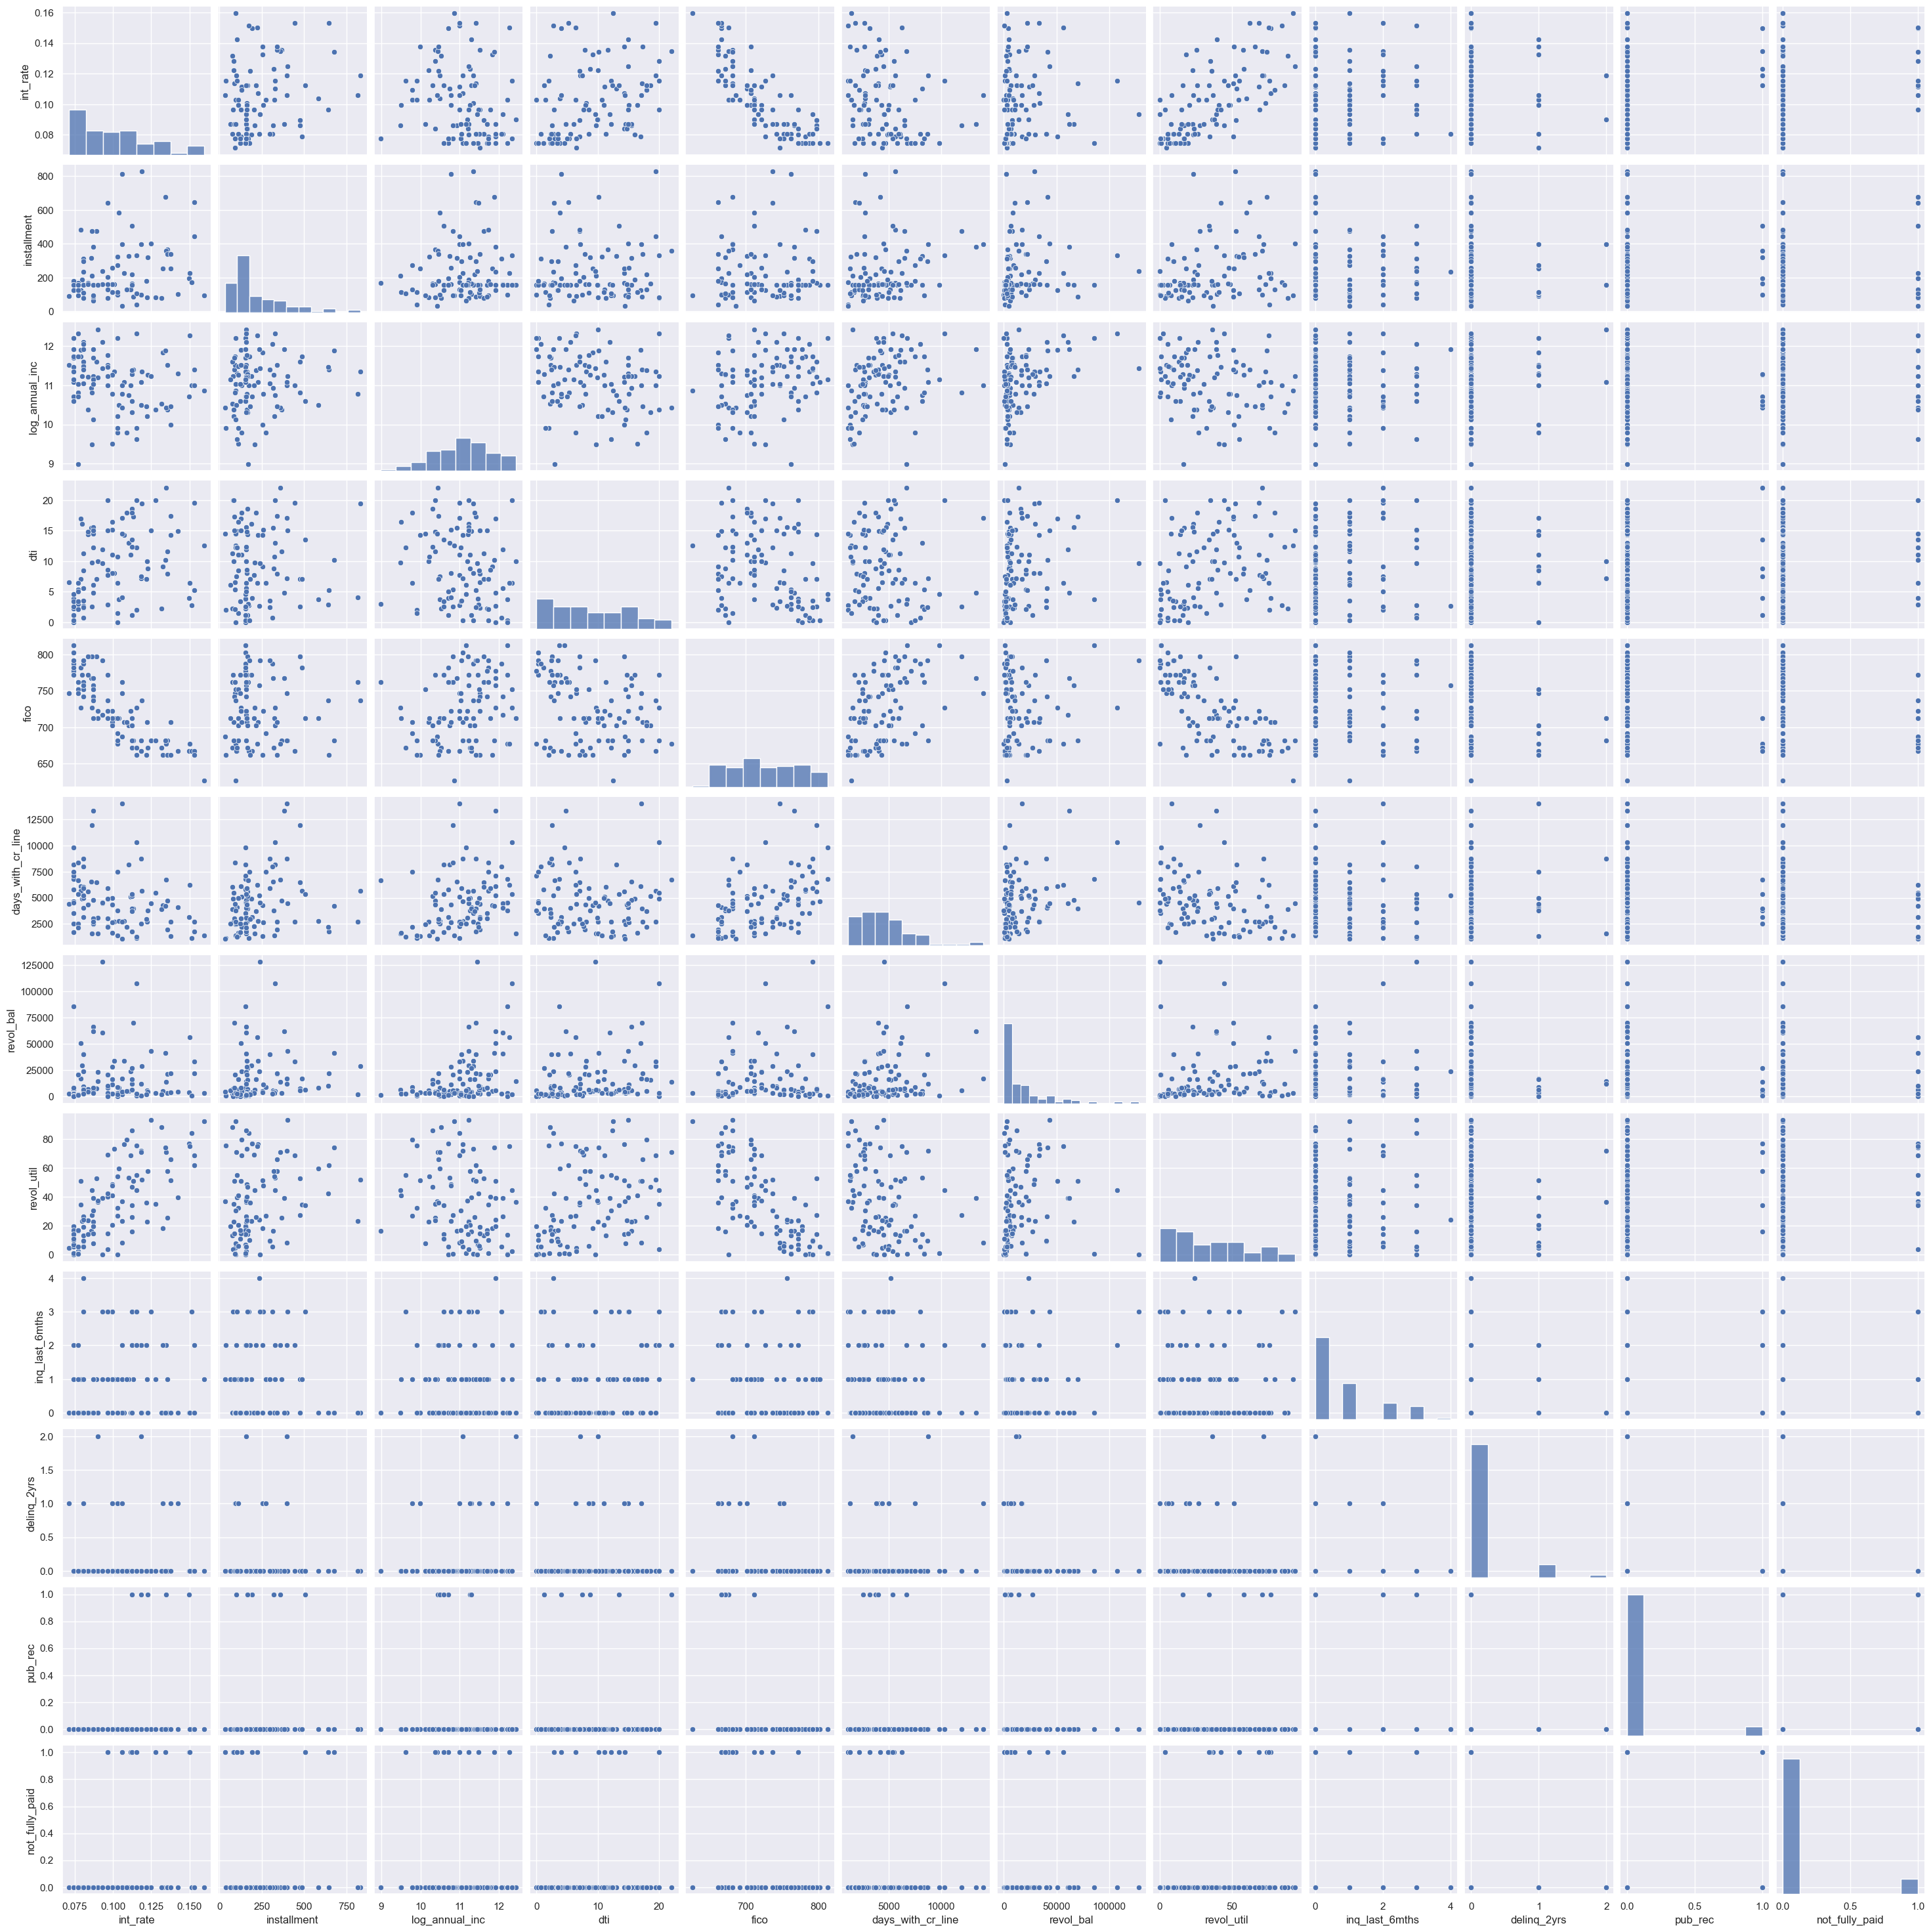

In [17]:
sns.pairplot(df)

### Heat map

/var/folders/w0/mkf6nqcx2_s0xg85xfrzd05h0000gn/T/ipykernel_79892/3264044555.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='grey', edgecolor='white', lw=0.5))


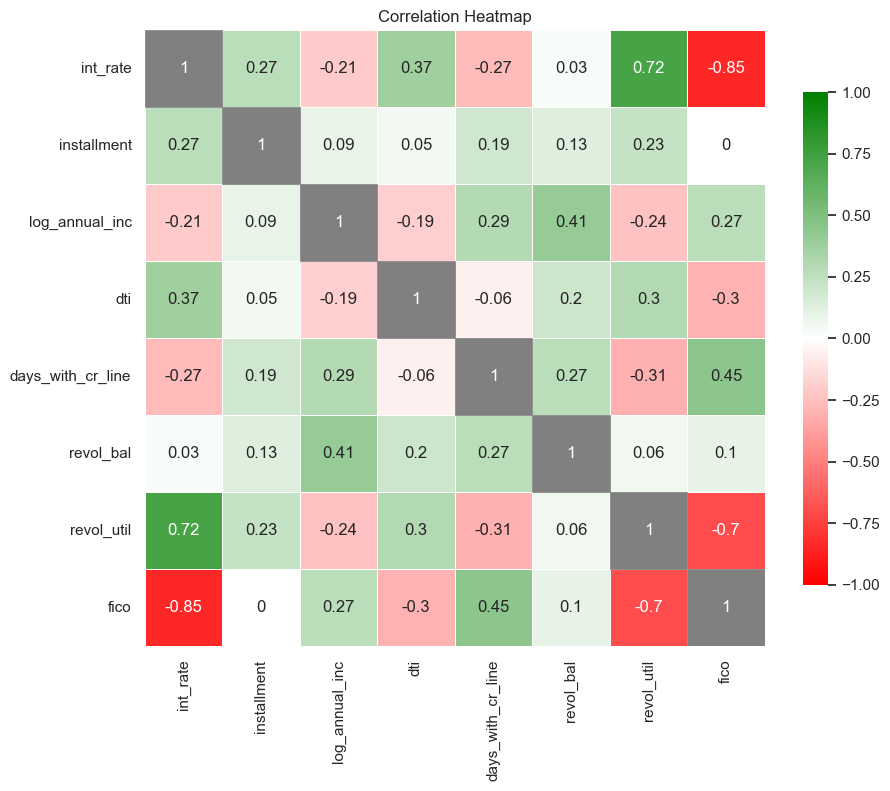

In [18]:
from matplotlib.colors import LinearSegmentedColormap

# Compute the correlation matrix and round it to 2 decimal places
corr_matrix = round(df_num.corr(), 2)

# Create a custom colormap from red to white to green
cmap = LinearSegmentedColormap.from_list('custom_cmap',
                                         ['red', 'white', 'green'],
                                         N=256)

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap=cmap, center=0, vmin=-1, vmax=1, 
                      linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})

# Grey out the values equal to 1
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if corr_matrix.iloc[i, j] == 1:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='grey', edgecolor='white', lw=0.5))

# Customize the heatmap
plt.title('Correlation Heatmap')
plt.show()

### Significant pair plots

Highlight plots with PMC >= 0.3

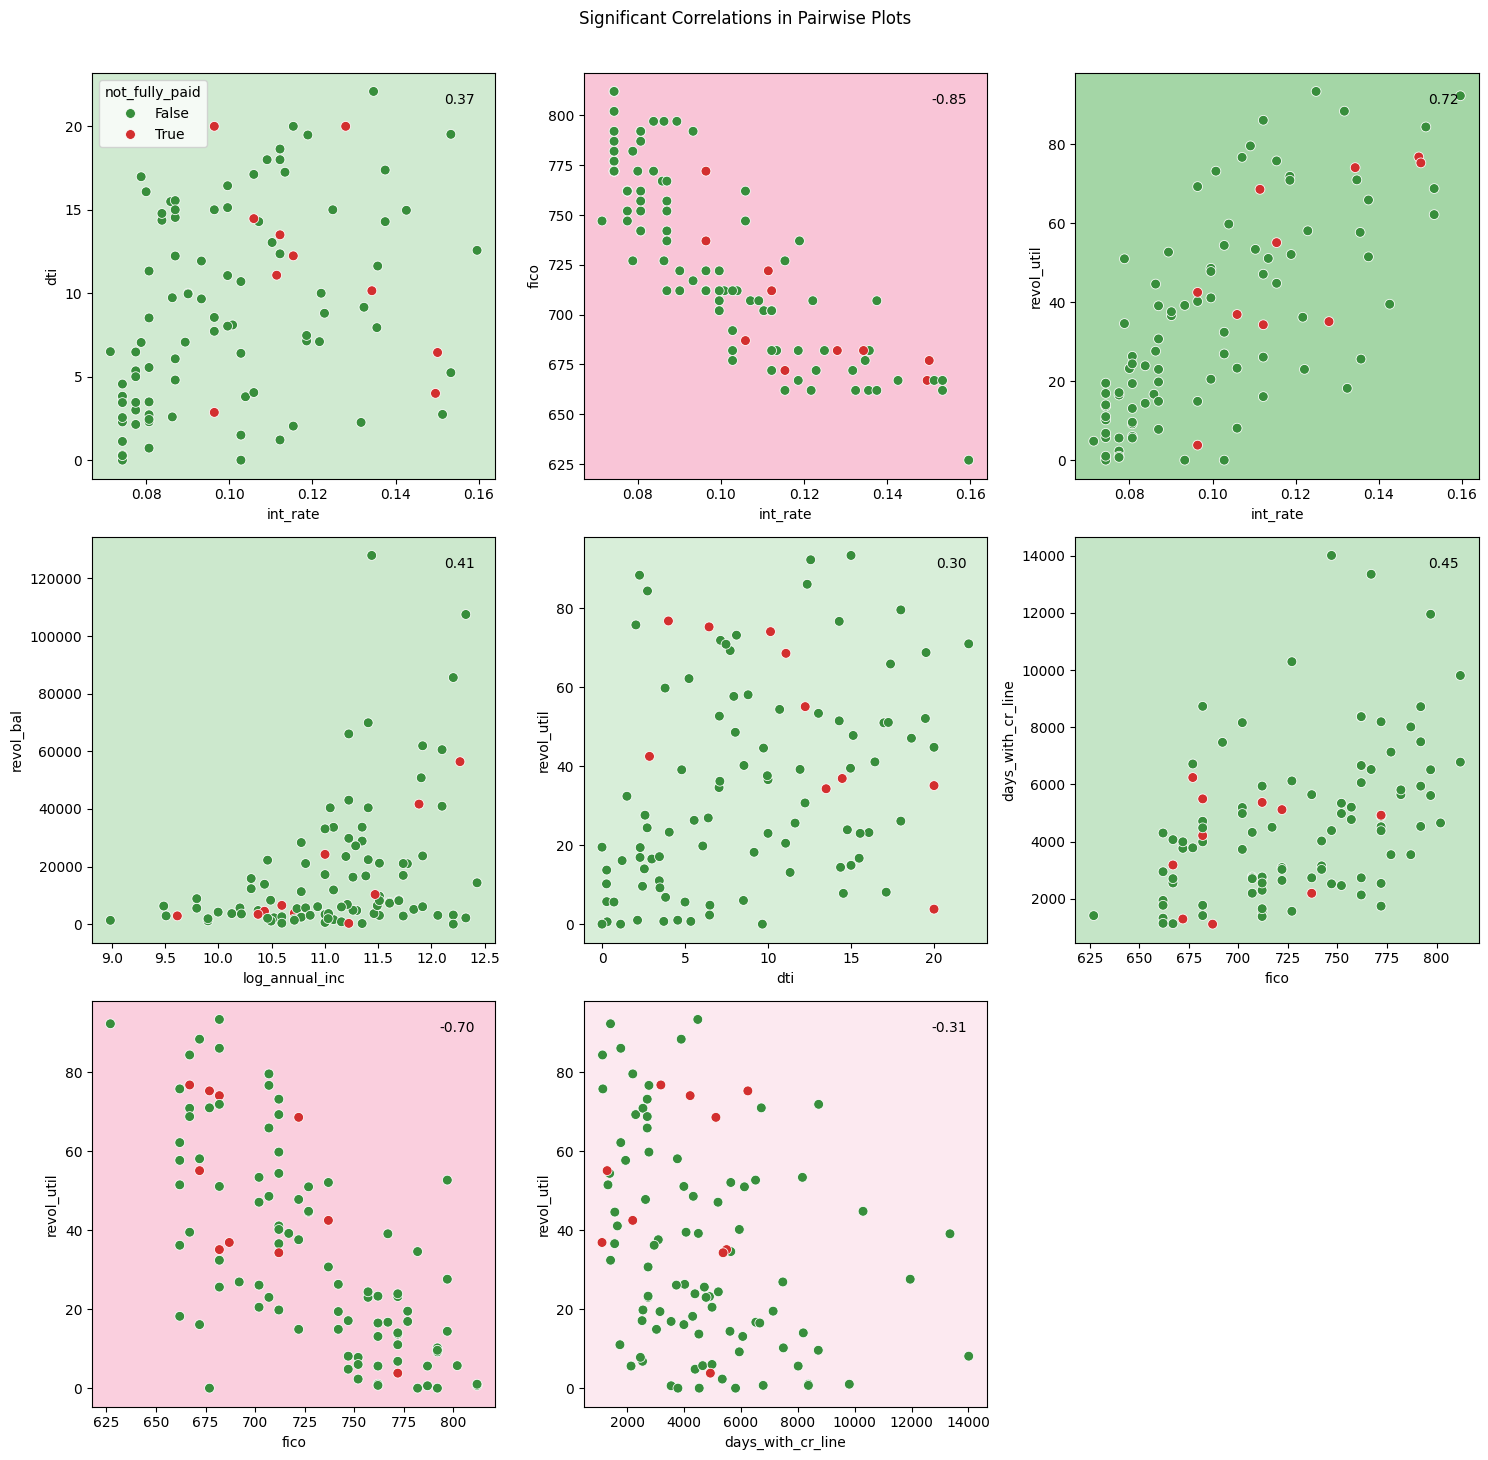

In [19]:
def get_significant_correlations(data, hue):
    # Compute the correlation matrix
    num_cols = data.select_dtypes(include=['number']).columns
    num_cols = [col for col in num_cols if col != hue]
    corr_matrix = data[num_cols].corr()

    significant_pairs = []

    # Identify significant correlations
    for i, x in enumerate(num_cols):
        for j, y in enumerate(num_cols):
            if i < j:  # Avoid redundant plotting
                corr = corr_matrix.loc[x, y]
                if abs(corr) >= 0.3:
                    significant_pairs.append((x, y, corr))

    return significant_pairs, corr_matrix

def plot_significant_correlations(data, significant_pairs, hue, palette):
    plt.style.use('default')  # Reset to default Matplotlib style

    # Define colour mapping for the dots
    dot_palette = {True: '#d32f2f', False: '#388e3c'}  # Darker red and green

    # Create a single figure to collate significant graphs
    num_plots = len(significant_pairs)
    rows = int(np.ceil(num_plots / 3))
    
    fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5), sharex=False, sharey=False)
    axes = axes.flatten()

    # Plot significant correlations
    for i, (x, y, corr) in enumerate(significant_pairs):
        ax = axes[i]
        sns.scatterplot(data=data, x=x, y=y, hue=hue, palette=dot_palette, ax=ax, s=50, alpha=1.0)

        # Add correlation coefficient text
        ax.text(0.95, 0.95, f'{corr:.2f}', transform=ax.transAxes,
                ha='right', va='top', fontsize=10, color='black')

        # Set the background colour based on direction of correlation
        if corr >= 0:
            ax.set_facecolor('#81c784' if corr > 0 else '#ef5350')
        else:
            ax.set_facecolor('#c8e6c9' if corr > 0 else '#f8bbd0')

        

        # Set background opacity based on correlation strength
        ax.patch.set_alpha(abs(corr))

        #if corr >= 0.5:
        #    ax.set_facecolor('#81c784' if corr > 0 else '#ef5350')
        #elif abs(corr) >= 0.3:
        #    ax.set_facecolor('#a5d6a7' if corr > 0 else '#f48fb1')
        #else:
        #    ax.set_facecolor('#c8e6c9' if corr > 0 else '#f8bbd0')

        # Ensure background colour is applied consistently
        #ax.patch.set_alpha(0.3)  # Light transparency

        # Remove legend from all but the first plot
        if i != 0:
            ax.get_legend().remove()

    # Hide any unused subplots
    for ax in axes[num_plots:]:
        ax.axis('off')

    plt.suptitle('Significant Correlations in Pairwise Plots', y=0.97)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Define colour palette for 'True' and 'False'
palette = {True: '#ff9999', False: '#99ff99'}  # Pastel red and green

# Get significant correlations
significant_pairs, corr_matrix = get_significant_correlations(df, hue='not_fully_paid')

# Filter out uninformative graphs
filtered_pairs = [(x, y, corr) for x, y, corr in significant_pairs 
                  if len(df[x].unique()) > 10 and len(df[y].unique()) > 10]

# Plot the significant correlations
plot_significant_correlations(df, filtered_pairs, hue='not_fully_paid', palette=palette)

### Purpose regression plots

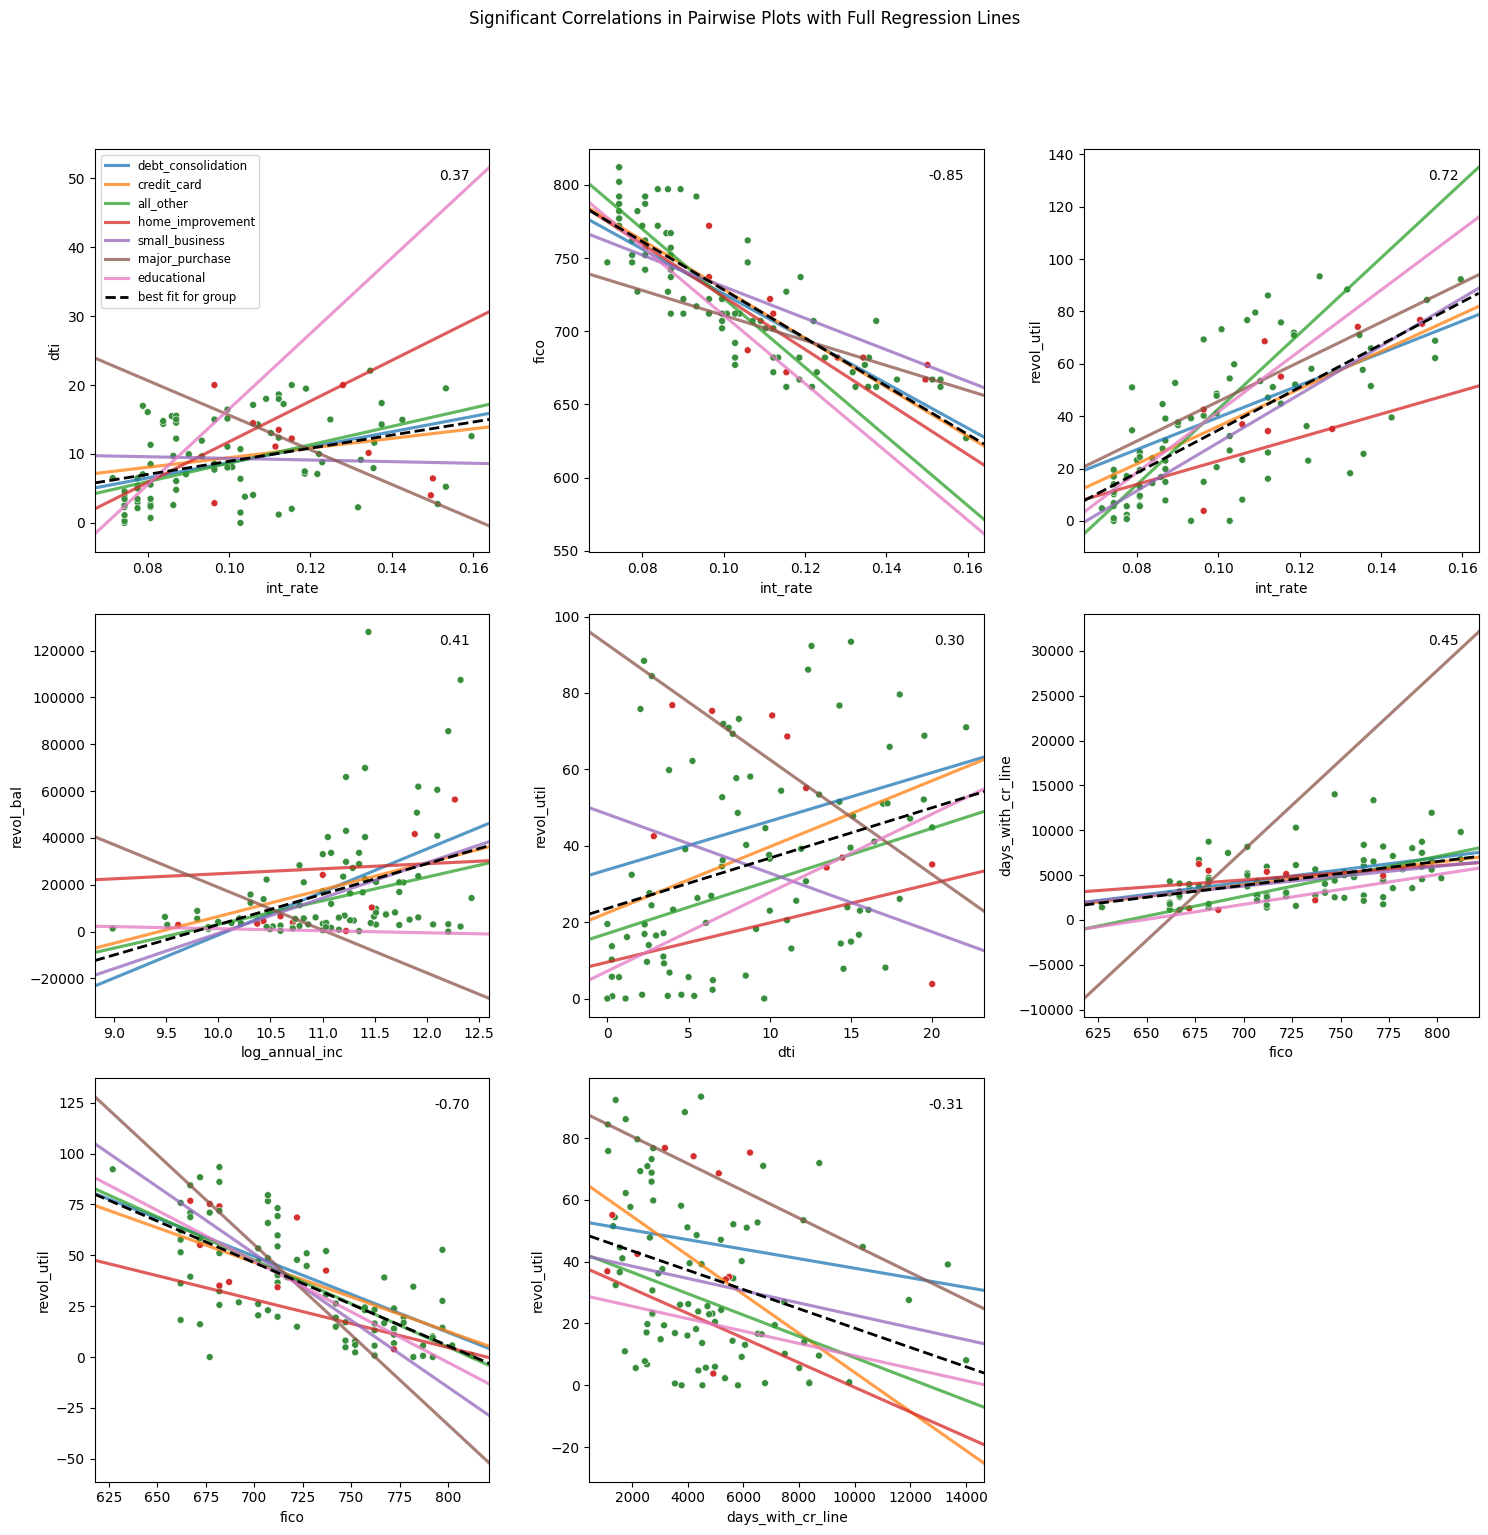

In [20]:
def plot_significant_correlations_with_full_regression(data, significant_pairs, hue, palette):
    plt.style.use('default')  # Reset to default Matplotlib style

    # Define color mapping for the dots
    dot_palette = {True: '#d32f2f', False: '#388e3c'}  # Darker red and green
    purpose_palette = sns.color_palette('tab10', n_colors=len(data['purpose'].unique()))

    # Create a single figure to collate significant graphs
    num_plots = len([pair for pair in significant_pairs if abs(pair[2]) >= 0.3])
    rows = int(np.ceil(num_plots / 3))

    fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5), sharex=False, sharey=False)
    axes = axes.flatten()

    plot_index = 0
    added_legend = False

    # Plot significant correlations with regression lines for abs(corr) >= 0.3
    for x, y, corr in significant_pairs:
        if abs(corr) >= 0.3:
            ax = axes[plot_index]
            sns.scatterplot(data=data, x=x, y=y, hue=hue, palette=dot_palette, ax=ax, s=25, alpha=1.0, legend=False)

            unique_purposes = data['purpose'].unique()
            for idx, purpose in enumerate(unique_purposes):
                subset = data[data['purpose'] == purpose]
                sns.regplot(x=subset[x], y=subset[y], ax=ax, scatter=False, label=purpose, ci=None, truncate=False, 
                            color=purpose_palette[idx], line_kws={'alpha': 0.75})

            # Add the overall regression line in bold black
            sns.regplot(data=data, x=x, y=y, ax=ax, scatter=False, ci=None, truncate=False, color='black', line_kws={'linewidth': 2,  'linestyle': '--'}, label='best fit for group')

            if not added_legend:
                ax.legend(loc='best', fontsize='small')
                added_legend = True

            # Add correlation coefficient text
            ax.text(0.95, 0.95, f'{corr:.2f}', transform=ax.transAxes,
                    ha='right', va='top', fontsize=10, color='black')

            plot_index += 1

    # Hide any unused subplots
    for ax in axes[plot_index:]:
        ax.axis('off')

    plt.suptitle('Significant Correlations in Pairwise Plots with Full Regression Lines', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Use the new function to plot significant correlations with full regression lines
plot_significant_correlations_with_full_regression(df, filtered_pairs, hue='not_fully_paid', palette=palette)


#### Purpose and outcome plots

## Insights

# Discussion